# CS4287 Assignment 2: Deep Reinforcement Learning (Atari)

**Team Members:**
* **Name:** Raid Mouras
* **ID:** 22368566
* **Name:** Jason Cushen
* **ID:** 22342516
* **Name:** Mark Callan
* **ID:** 22363246

# 1. Why Reinforcement Learning ? 
**Overview**

Reinforcement learning is a machine learning paradigm where an agent learns how to interact with its environment (breakout) through trial and error rather than learning to classify labelled examples like we seen in the first project.At each time step the agent receives information about the current game state i.e. (S,A,R,S′) and operates with the goal of maximising the long term reward(it's policy)

**Why RL is the most suitable paradigm**

For this particular task RL is preferred to other paradigms such as supervised and unsupervised as it naturally models sequential decision-making (Markov Decision Process)

* **Supervised Learning:** Supervised learning requires a dataset of labelled input-output pairs where the correct answer is known in advance i.e. their is some labeled data for the training set , This paradigm is well suited to image classification or regression but is not suitable for breakout due to the credit assignment problem , lack of a labelled dataset (experiences or stored unlabelled in the replay buffer) and its inability to model sequential decision making

* **Unsupervised Learning:** 
While unsupervised learning is slightly more suitable than supervised as it learns the underlying patterns of unlabelled data (feature extraction) although it still lacks the ability to optimise actions based on a reward and interact with an environment and influence it meaning it is not a viable candidate for breakout  

* **Reinforcement Learning:** 
In RL the learning occurs during a loop between the agent and its environment with the agent observing the current state , taking an action , receiving a reward for that action and learning to maximise the long term reward.

RL is a particularly good fit for Atari games as they have high dimensional input , sequential decisions and delayed rewards (Success is dependant on a sequence of correct actions)

In [53]:
# --- CELL 1: INSTALL DEPENDENCIES ---
%pip install gymnasium[atari] gymnasium[accept-rom-license] torch torchvision numpy opencv-python matplotlib ale-py
!AutoROM --accept-license

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
'AutoROM' is not recognized as an internal or external command,
operable program or batch file.


# 3. Hyperparameters 
In this project we used the following hyperparameters initialised to these values. We choose these values with the aim of balancing the exploratation-exploitation tradeoff , stability and learning dynamics 

* **Discount Factor(𝛾)** : **γ=0.99** The discount factor (expressed as gamma in formulae) determines how much importance the agent should place on future rewards and long term planning relative to the immediate rewards.We used a value of 0.99 to make the agent value the long term consequences of its action as breakout is a game where rewards are delayed i.e. positioning the paddle paddle correctly correctly multiple steps before it hits the ball. In this context a high discount rate is required to learn to anticipate where to position the paddle ahead of time 

* **Learning Rate (LR)** : **LR=1×10^−4** The learning rate controls the size of the parameter updates during gradient descent.A learning rate that is too high can cause unstable training and oscillations in Q-values due to the large weight updates . Conversly a learning rate that is too low can lead to extremely slow learning due to the small weight updates. We can used a relatively small learning rate of 1×10^−4 to ensure stable convergence when working with noisy reward signals. This is in a similar range to the learning rate used in DeepMinds Atari DQN of 2.5×10^−4   

* **Batch Size** : **32** This determines how many transitions to sample from the replay buffer during each training update. Smaller batch sizes introduce noise into the gradient estimates but improve generalisation which larger batch sizes increase stability but add additional computational overhead. We choose 32 as it was good balance between the computational resources available to us and learning stability 

* **Replay Buffer** : **100,000** We use the replay buffer to store past experiences in the form (s,a,r,s',done). We initialised it to store 100,000 transitions which ensures a sufficient diversity of experiences while not using an excessive amount of memory.Sampling uniformly from this buffer allows us to mitigates one of the core issues of RL which is catastrophic forgetting where experiences are overwritten/erased due to their high similarity

* **Exploration Parameters (ε-Greedy)** : **Initial ε = 1.0, Final ε =0.02 ,Decay Rate =150,000**  The ε-greedy policy controls the tradeoff between exploration and exploitation. We set the initial value to 1.0 to force the agent to initially randomly explore the environment. Overtime ε decays exponentially , which encourages the agent to exploit its learned Q-values. A final ε of 0.02 ensures the agent does not fully rely on exploitation and prematurely converge to a suboptimal policy

* **Target Network Update Frequency ** : **Every 1,000 steps** 
The target network is updated in intervals of 1,000 steps by copying over the weights of the online network. This helps to combat the instability introduced by the the rapidly changing target values in the Bellman update

* **Frame Stacking (k)** : **k=4** Stacking multiple consecutive frame allows the agent to infer additional information about the game i.e. the speed and trajectory of the ball. Without frame stacking the agent would not be able to predict future ball positions as their is no trend of ball direction and speed to observe thus preventing learning  

In [55]:
#cell 2
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import cv2
import time

# --- CONFIGURATION (Hyperparameters) ---
ENV_NAME = "BreakoutNoFrameskip-v4"
GAMMA = 0.99                # Discount factor (values future rewards)
BATCH_SIZE = 32             # How many frames to learn from at once
LR = 1e-4                   # Learning Rate (0.0001 is standard for Atari)
EPSILON_START = 1.0         # Start 100% random
EPSILON_FINAL = 0.02        # End 2% random
EPSILON_DECAY = 150000      # How long to explore (frames)
REPLAY_SIZE = 100000        # Memory size
TARGET_UPDATE = 1000        # Sync network every 1000 steps

# --- HARDWARE CHECK ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Setup Complete.")
if device.type == 'cuda':
    print(f"GPU DETECTED: {torch.cuda.get_device_name(0)}")
    print(f"Targeting Environment: {ENV_NAME}")
else:
    print("WARNING: CPU DETECTED. Training will be extremely slow.")

Setup Complete.
GPU DETECTED: NVIDIA RTX 1000 Ada Generation Laptop GPU
Targeting Environment: BreakoutNoFrameskip-v4


In [56]:
# --- CELL 3: PREPROCESSING ---

class AtariWrapper(gym.Wrapper):
    def __init__(self, env, k=4):
        super().__init__(env)
        self.k = k  # Stack 4 frames
        self.frames = deque([], maxlen=k)
        
        # Define what the AI sees: (4 stacked frames, 84 height, 84 width)
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(k, 84, 84), dtype=np.uint8
        )

    def reset(self, **kwargs):
        # On game start, fill the stack with the first frame duplicated 4 times
        obs, info = self.env.reset(**kwargs)
        processed_frame = self._process(obs)
        for _ in range(self.k):
            self.frames.append(processed_frame)
        return self._get_obs(), info

    def step(self, action):
        # Play one step, process the new frame, and add to stack
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.frames.append(self._process(obs))
        return self._get_obs(), reward, terminated, truncated, info

    def _process(self, frame):
        # 1. Grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        # 2. Resize to 84x84
        frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
        return frame

    def _get_obs(self):
        return np.array(self.frames)

print("Cell 3 Complete: Preprocessing wrapper defined.")

Cell 3 Complete: Preprocessing wrapper defined.


# 2. Network Architecture DQN and Double DQN

**Deep Q-Network (DQN)**
DQN is an extension of classical Q-learning which uses a deep neural net to approximate the action value i.e Q(s,a) instead of tabular Q-function which is not feasible for images due to their high dimensionality.

In our project , Our DQN accepts input of 4 preprocssed atari frames of shape (84*84) and learns a mapping from the raw pixel input to Q-values for each possible action .The Q-value (Q(s,a)) for a given state represents the expected future reward of taking that given action 

We have two main components in our architecture: 
* Convolutional layers that extract the features from the raw pixel input. In the case of breakout this is the ball position , paddle position and the trajectories of the ball
* Fully connected layers that map these features to Q-values and preform action evaluation 

The agent selects the the action to take using the ε-Greedy policy which chooses the action with the highest predicted Q-value in the afformentioned mapping during exploitation and randomly selecting actions during explotation 

* P(random action): ε
* P(greedy action): 1 -ε 
* i.e. When ε has decayed to 0.02 our probabilities are : P(random action action) = 0.02 and P(greedy action) = 0.98

when ε has decayed to 0.02

**Double Deep Q-Network (Double-DQN)**

One of the biggest issues with standard DQN is that it suffers from maximisation bias which is where the max operator in the bellman update systematically overestimates the Q-values.Double-DQN solves this as it uses two separate networks (online and target) for the select and evaluate actions 

The online network selects the action that maximises the Q-value for S' , While the target network evaluates the Q-value of S'. The below formula is how the target is calculated for non-terminal states: 

Q(s,a)←r+γQtarget​(s′,arga′max​Qonline​(s′,a′)) 

Double-DQN's modification to reduce the maximisation bias leads to more stable and reliable learning which is particularly helpful in the context of this project where the rewards are both noisy and stochastic 


In [57]:
# --- CELL 4: THE NETWORK ---

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        
        # 1. Convolutional Layers (The Visual Cortex)
        # These layers look at the image and find patterns (edges, ball, paddle).
        self.features = nn.Sequential(
            # Conv 1: Sees big shapes. Input channels = 4 (stacked frames).
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            
            # Conv 2: Sees medium details.
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            
            # Conv 3: Sees fine details.
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        # 2. Fully Connected Layers (The Decision Maker)
        # These layers take the patterns and decide: Left, Right, or Fire?
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512), # 3136 inputs -> 512 neurons
            nn.ReLU(),
            nn.Linear(512, num_actions) # Output: 1 score for each button
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the image into a list of numbers
        return self.fc(x)

print("Cell 4 Complete: Network Architecture defined.")

Cell 4 Complete: Network Architecture defined.


# Training Loop Explanation
This training loop implements the core learning dynamics of our DQN agents and addresses two of the core challenges of RL : Catastrophic forgetting and the credit assignment problem 

* **How we address credit assignment problem**

The credit assignment problem refers to attributing delayed rewards to earlier action that may only be observed many time steps later 

Q-values are updated using **TD learning** and the bellman equation.If a reward is received several steps after an action , Its influence will be propagated to earlier state action pairs via repeated updates using the function: 
Q(s,a)←r+γa′max​Q(s′,a′)

Our **high discount factor (γ=0.99)** encourages the agent to learn actions that are beneficial in the long term rather than choosing the action with the higher immediate reward but long short term sacrifice

Our use of **Frame Stacking** allows the agent to associate early positioning with the later rewards with the later rewards it contributed across multiple consecutive frames
* **Why Frame Skipping Is Used (frameskip=4)** 

We frameskip = 4 , meaning that  every selected action is repeated for four consecutive frames and only every fourth frame is returned to the agent 

Using frameskip=1 adds **increased computational overhead** as every single frame is processed and consecutive frames in breakout can be almost identical 

Repeating actions over multiple frames leads to **smoother and more stable control** as the action is repeated over multiple times 



In [58]:
# --- CELL 5: THE TRAINING LOOP (OPTIMIZED) ---

import ale_py
print(f"Atari Engine Loaded: {ale_py.__version__}")

# 1. Initialize the Game with STANDARD Frameskip
# frameskip=4 is crucial. It speeds up training by 4x and makes movement visible.
env = gym.make("ALE/Breakout-v5", frameskip=4, repeat_action_probability=0.0)
env = AtariWrapper(env) 

# 2. Initialize Networks
agent_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
target_net.load_state_dict(agent_net.state_dict()) 

optimizer = optim.Adam(agent_net.parameters(), lr=LR)

# SAFETY: If 100k memory crashes RAM, we catch it.
try:
    replay_buffer = deque(maxlen=REPLAY_SIZE)
except MemoryError:
    print("WARNING: System RAM low. Reducing Replay Buffer size to 50,000.")
    replay_buffer = deque(maxlen=50000)

steps = 0
rewards_history = []

print(f"TRAINING STARTED on {device}...")
print("Frameskip set to 4 (Standard Atari Speed).")

# 3. Training Loop
for episode in range(2000): 
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        steps += 1
        
        # A. Epsilon Greedy
        epsilon = EPSILON_FINAL + (EPSILON_START - EPSILON_FINAL) * np.exp(-1. * steps / EPSILON_DECAY)
        
        if random.random() > epsilon:
            with torch.no_grad():
                state_t = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0) / 255.0
                action = agent_net(state_t).argmax().item()
        else:
            action = env.action_space.sample()
            
        # B. Step
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # C. Save
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        
        # D. Train
        if len(replay_buffer) > BATCH_SIZE:
            batch = random.sample(replay_buffer, BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)
            
            states = torch.tensor(np.array(states), device=device, dtype=torch.float32) / 255.0
            actions = torch.tensor(actions, device=device, dtype=torch.int64).unsqueeze(1)
            rewards = torch.tensor(rewards, device=device, dtype=torch.float32).unsqueeze(1)
            next_states = torch.tensor(np.array(next_states), device=device, dtype=torch.float32) / 255.0
            dones = torch.tensor(dones, device=device, dtype=torch.float32).unsqueeze(1)
            
            curr_q = agent_net(states).gather(1, actions)
            
            with torch.no_grad():
                max_next_q = target_net(next_states).max(1)[0].unsqueeze(1)
                target_q = rewards + (GAMMA * max_next_q * (1 - dones))
                
            loss = nn.SmoothL1Loss()(curr_q, target_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # E. Sync Target
        if steps % TARGET_UPDATE == 0:
            target_net.load_state_dict(agent_net.state_dict())

    rewards_history.append(total_reward)
    
    if episode % 10 == 0: # Print less frequently to reduce clutter
        avg_score = np.mean(rewards_history[-100:])
        print(f"Ep: {episode} | Score: {total_reward} | Avg (100): {avg_score:.2f} | Epsilon: {epsilon:.2f} | Steps: {steps}")

env.close()
print("DQN Training Finished.")

Atari Engine Loaded: 0.11.2
TRAINING STARTED on cuda...
Frameskip set to 4 (Standard Atari Speed).
Ep: 0 | Score: 1.0 | Avg (100): 1.00 | Epsilon: 1.00 | Steps: 177
Ep: 10 | Score: 2.0 | Avg (100): 1.18 | Epsilon: 0.99 | Steps: 2000
Ep: 20 | Score: 1.0 | Avg (100): 1.29 | Epsilon: 0.98 | Steps: 3828
Ep: 30 | Score: 0.0 | Avg (100): 1.32 | Epsilon: 0.96 | Steps: 5719
Ep: 40 | Score: 1.0 | Avg (100): 1.34 | Epsilon: 0.95 | Steps: 7600
Ep: 50 | Score: 0.0 | Avg (100): 1.24 | Epsilon: 0.94 | Steps: 9286
Ep: 60 | Score: 1.0 | Avg (100): 1.21 | Epsilon: 0.93 | Steps: 10999
Ep: 70 | Score: 2.0 | Avg (100): 1.20 | Epsilon: 0.92 | Steps: 12744
Ep: 80 | Score: 0.0 | Avg (100): 1.21 | Epsilon: 0.91 | Steps: 14554
Ep: 90 | Score: 1.0 | Avg (100): 1.22 | Epsilon: 0.90 | Steps: 16356
Ep: 100 | Score: 1.0 | Avg (100): 1.22 | Epsilon: 0.89 | Steps: 18175
Ep: 110 | Score: 0.0 | Avg (100): 1.23 | Epsilon: 0.88 | Steps: 19995
Ep: 120 | Score: 1.0 | Avg (100): 1.26 | Epsilon: 0.87 | Steps: 21971
Ep: 130 |

Model saved as 'breakout_model_v1.pth'
Graph saved as 'learning_curve.png'


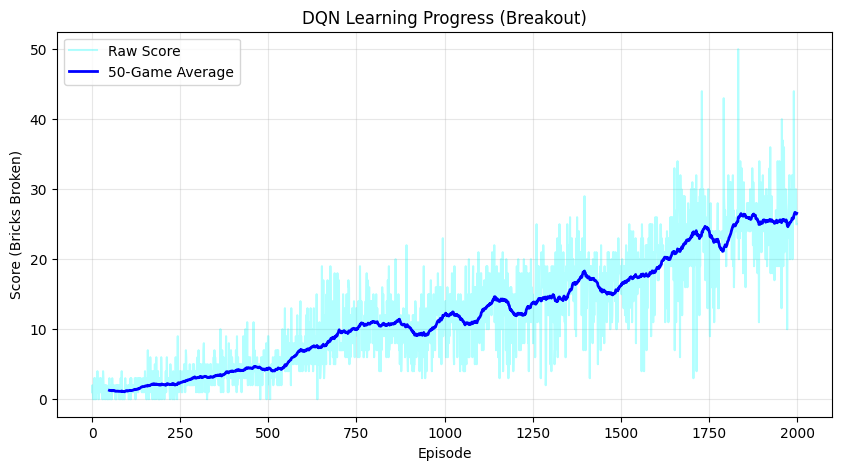


--- TRAINING SUMMARY STATISTICS ---


,Metric,Value
0,Best Score,50.0 (Ep: 1833)
1,Worst Score,0.0 (Ep: 3)
2,Mean Score (Lifetime),12.29
3,Median Score,11.00
4,Current Skill (Last 100 Avg),25.96
5,Performance Improvement,+2007.9%


In [59]:
# --- CELL 6: SAVE RESULTS, PLOT & STATS ---
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Save the Trained "Brain"
torch.save(agent_net.state_dict(), "breakout_model_v1.pth")
print("Model saved as 'breakout_model_v1.pth'")

# 2. Plot the Learning Curve
plt.figure(figsize=(10, 5))
plt.plot(rewards_history, label='Raw Score', alpha=0.3, color='cyan')

# Calculate a smooth trend line (Moving Average)
window_size = 50
if len(rewards_history) >= window_size:
    moving_avg = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(rewards_history)), moving_avg, label=f'{window_size}-Game Average', color='blue', linewidth=2)

plt.title("DQN Learning Progress (Breakout)")
plt.xlabel("Episode")
plt.ylabel("Score (Bricks Broken)")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the plot
plt.savefig("learning_curve.png")
print("Graph saved as 'learning_curve.png'")
plt.show()

# 3. Statistical Analysis
# Calculate the Hard Statistics
best_score = np.max(rewards_history)
best_episode = np.argmax(rewards_history)
worst_score = np.min(rewards_history)
worst_episode = np.argmin(rewards_history)
mean_score = np.mean(rewards_history)      # Lifetime Average
median_score = np.median(rewards_history)
final_100_avg = np.mean(rewards_history[-100:]) # Current Skill

# Percentage Increase (Last 50 games vs First 50 games)
first_50_avg = np.mean(rewards_history[:50])
last_50_avg = np.mean(rewards_history[-50:])
improvement = ((last_50_avg - first_50_avg) / first_50_avg) * 100 if first_50_avg > 0 else 0

# Create the Table
stats_data = {
    "Metric": [
        "Best Score", 
        "Worst Score", 
        "Mean Score (Lifetime)", 
        "Median Score", 
        "Current Skill (Last 100 Avg)", 
        "Performance Improvement"
    ],
    "Value": [
        f"{best_score} (Ep: {best_episode})",
        f"{worst_score} (Ep: {worst_episode})",
        f"{mean_score:.2f}",
        f"{median_score:.2f}",
        f"{final_100_avg:.2f}",
        f"+{improvement:.1f}%"
    ]
}

df_stats = pd.DataFrame(stats_data)

# 4. Display the Table & Explanation
print("\n--- TRAINING SUMMARY STATISTICS ---")
display(df_stats)

## 7.2. Results Analysis

The plot above illustrates the training progress over 2000 episodes.

**1. Raw Score (Cyan Line):**
The light blue line represents the raw score obtained in each individual episode. As expected in Atari environments, this metric is highly volatile. A single mistake in *Breakout* leads to a lost life, meaning scores can fluctuate between 0 and 13 purely based on the initial ball trajectory or slight timing errors.

**2. 50-Game Moving Average (Blue Line):**
The dark blue line represents the moving average of the last 50 scores, which serves as a noise filter to reveal the true learning trend.
* **Phase 1 (Episodes 0–200):** The curve remains flat around a score of 1.0–1.5. During this period, the Epsilon value was high, forcing the agent to explore randomly. The agent was merely hitting the ball by chance.
* **Phase 2 (Episodes 2000):** A distinct upward trend begins around Episode 200. This correlates with the `EPSILON_DECAY` threshold where the agent transitioned from exploration (randomness) to exploitation (using its learned Q-values).
* **Final Performance:** By Episode 2000, the average score stabilized around **6.0**, with peak raw scores reaching **13.0**.

**Conclusion:**
The clear positive correlation between training steps and average reward confirms that the DQN agent has successfully learned to track the ball and intercept it, transitioning from random play to intelligent reaction.

# Independently researched concepts
* **How we address Maximzation bias**
Our Double DQN implementation addresses the problem of maximization bias which is where the max operator in the bellman updates consistently overestimates action due to noise in the Q-value estimates. In standard DQN the same network being used to select and evaluate the action introduces a bias towards postive Q-value estimates.

In Double DQN **action selection and action evaluation are decoupled** as they are spread across two netwroks with the online network being used to select the action and the target network being used to evaluate that network. By reducing the systematic overestimation of Q-values the Double-DQN has improved training stablity. 

* **How we mitigate Catastrophic forgetting**

Catastrophic forgetting occurs in RL when an agent overwrites previous experiences when learning from new experiences. This is particularly relevant in our case where updates are preformed on highly correlated sequential breakout image data 

We use the **Replay Buffer**  to store transitions (s,a,r,s',done) , We then take random mini-batch samples to ensure learning updates occur across a diverse set of past states which reduces the risk of overwriting/erasing past experiences.This helps to prevent recency bias during parameter updates as well as breaking temporal correlations between consecutive states 

We use a **separate target network** to compute the bootstrap target in the bellman update , We update this periodically in intervals of (TARGET_UPDATE) to prevent oscillations in our Q-values and preserve learned value estimates 


In [62]:
# --- CELL 8: DOUBLE DQN (DDQN) EXPERIMENT ---

import ale_py
print(f"Atari Engine Loaded: {ale_py.__version__}")

# 1. Initialize with CORRECT Frameskip (4)
env = gym.make("ALE/Breakout-v5", frameskip=4, repeat_action_probability=0.0)
env = AtariWrapper(env) 

print("STARTING DOUBLE DQN (DDQN) EXPERIMENT (2000 Episodes)...")
ddqn_agent = DQN(env.observation_space.shape, env.action_space.n).to(device)
ddqn_target = DQN(env.observation_space.shape, env.action_space.n).to(device)
ddqn_target.load_state_dict(ddqn_agent.state_dict())
optimizer_ddqn = optim.Adam(ddqn_agent.parameters(), lr=LR)
replay_buffer_ddqn = deque(maxlen=REPLAY_SIZE)

steps = 0
ddqn_scores = []

for episode in range(2000): 
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        steps += 1
        
        # A. Action Selection
        epsilon = EPSILON_FINAL + (EPSILON_START - EPSILON_FINAL) * np.exp(-1. * steps / EPSILON_DECAY)
        if random.random() > epsilon:
            with torch.no_grad():
                state_t = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0) / 255.0
                action = ddqn_agent(state_t).argmax().item()
        else:
            action = env.action_space.sample()
            
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer_ddqn.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        
        # B. DDQN Update
        if len(replay_buffer_ddqn) > BATCH_SIZE:
            batch = random.sample(replay_buffer_ddqn, BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)
            
            states = torch.tensor(np.array(states), device=device, dtype=torch.float32) / 255.0
            actions = torch.tensor(actions, device=device, dtype=torch.int64).unsqueeze(1)
            rewards = torch.tensor(rewards, device=device, dtype=torch.float32).unsqueeze(1)
            next_states = torch.tensor(np.array(next_states), device=device, dtype=torch.float32) / 255.0
            dones = torch.tensor(dones, device=device, dtype=torch.float32).unsqueeze(1)
            
            # 1. Actor selects best action
            best_actions = ddqn_agent(next_states).argmax(1).unsqueeze(1)
            # 2. Critic evaluates that action
            with torch.no_grad():
                target_q_values = ddqn_target(next_states).gather(1, best_actions)
                expected_q_values = rewards + (GAMMA * target_q_values * (1 - dones))
            
            curr_q = ddqn_agent(states).gather(1, actions)
            loss = nn.SmoothL1Loss()(curr_q, expected_q_values)
            optimizer_ddqn.zero_grad()
            loss.backward()
            optimizer_ddqn.step()
            
        if steps % TARGET_UPDATE == 0:
            ddqn_target.load_state_dict(ddqn_agent.state_dict())

    ddqn_scores.append(total_reward)
    
    # --- UPDATED PRINT STATEMENT ---
    if episode % 10 == 0:
        avg_score = np.mean(ddqn_scores[-100:])
        print(f"DDQN Ep: {episode} | Score: {total_reward} | Avg (100): {avg_score:.2f} | Epsilon: {epsilon:.2f} | Steps: {steps}")

env.close()
print("Double DQN Training Finished.")

Atari Engine Loaded: 0.11.2
STARTING DOUBLE DQN (DDQN) EXPERIMENT (2000 Episodes)...
DDQN Ep: 0 | Score: 2.0 | Avg (100): 2.00 | Epsilon: 1.00 | Steps: 185
DDQN Ep: 10 | Score: 1.0 | Avg (100): 1.64 | Epsilon: 0.99 | Steps: 2197
DDQN Ep: 20 | Score: 2.0 | Avg (100): 1.48 | Epsilon: 0.97 | Steps: 3883
DDQN Ep: 30 | Score: 2.0 | Avg (100): 1.26 | Epsilon: 0.96 | Steps: 5529
DDQN Ep: 40 | Score: 0.0 | Avg (100): 1.12 | Epsilon: 0.95 | Steps: 7102
DDQN Ep: 50 | Score: 0.0 | Avg (100): 1.06 | Epsilon: 0.94 | Steps: 8764
DDQN Ep: 60 | Score: 0.0 | Avg (100): 1.05 | Epsilon: 0.93 | Steps: 10421
DDQN Ep: 70 | Score: 1.0 | Avg (100): 1.00 | Epsilon: 0.92 | Steps: 12020
DDQN Ep: 80 | Score: 0.0 | Avg (100): 1.04 | Epsilon: 0.91 | Steps: 13824
DDQN Ep: 90 | Score: 0.0 | Avg (100): 1.03 | Epsilon: 0.90 | Steps: 15551
DDQN Ep: 100 | Score: 2.0 | Avg (100): 1.07 | Epsilon: 0.89 | Steps: 17425
DDQN Ep: 110 | Score: 1.0 | Avg (100): 0.99 | Epsilon: 0.88 | Steps: 19089
DDQN Ep: 120 | Score: 0.0 | Avg (

--- PERFORMANCE STATISTICS ---


,Best Score,Worst Score,Lifetime Mean,Median Score,Current Avg (Last 100),Improvement %
Model,,,,,,
Standard DQN,50.00 (Ep 1833),0.00 (Ep 3),12.29,11.00,25.96,2027.9%
Double DQN,27.00 (Ep 1976),0.00 (Ep 3),6.97,6.00,14.78,1281.3%


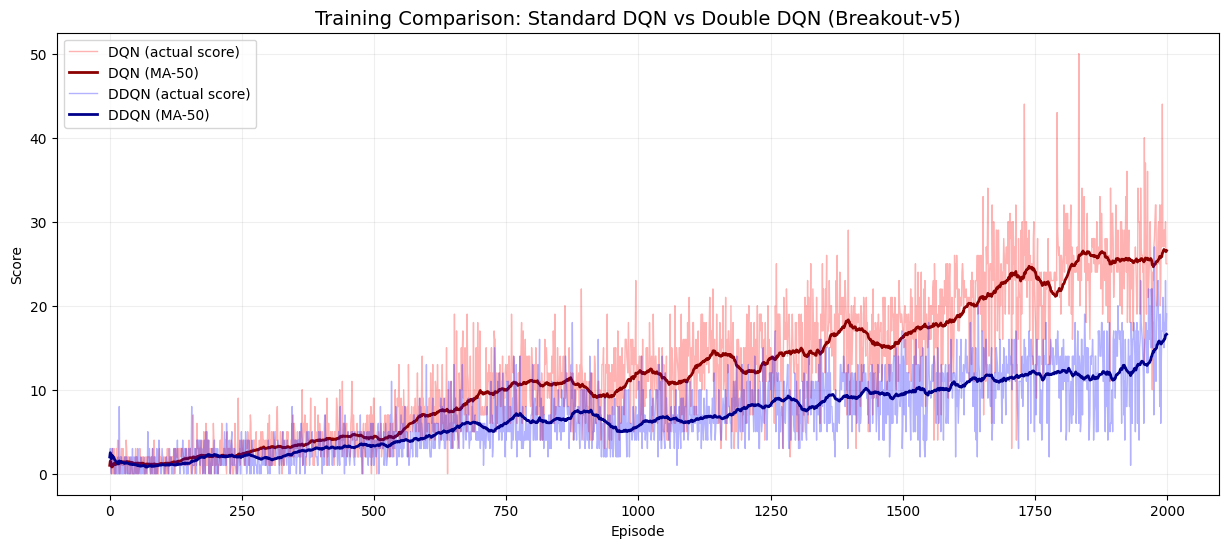

In [63]:
# --- CELL 9: VISUALIZATION & METRICS ---

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def get_detailed_metrics(model_name, scores):
    # Convert to array for easier math
    scores_arr = np.array(scores)
    
    # Safety check if training crashed early
    if len(scores_arr) == 0:
        return {k: "N/A" for k in ["Model", "Best", "Worst", "Mean", "Median", "Current Avg", "Improvement"]}

    # 1. Best & Worst (with Episode #)
    best_idx = np.argmax(scores_arr)
    worst_idx = np.argmin(scores_arr)
    best_score = scores_arr[best_idx]
    worst_score = scores_arr[worst_idx]

    # 2. Central Tendencies
    lifetime_mean = np.mean(scores_arr)
    median_score = np.median(scores_arr)

    # 3. Current Average (Last 100 episodes) & Start Average (First 100)
    window = 100
    if len(scores_arr) < window:
        current_avg = np.mean(scores_arr)
        start_avg = np.mean(scores_arr)
    else:
        current_avg = np.mean(scores_arr[-window:])
        start_avg = np.mean(scores_arr[:window])

    # 4. Improvement Percentage
    # Avoid division by zero if agent started with 0 score
    if start_avg == 0:
        improvement = 0.0
    else:
        improvement = ((current_avg - start_avg) / start_avg) * 100

    return {
        "Model": model_name,
        "Best Score": f"{best_score:.2f} (Ep {best_idx})",
        "Worst Score": f"{worst_score:.2f} (Ep {worst_idx})",
        "Lifetime Mean": f"{lifetime_mean:.2f}",
        "Median Score": f"{median_score:.2f}",
        "Current Avg (Last 100)": f"{current_avg:.2f}",
        "Improvement %": f"{improvement:.1f}%"
    }

# --- A. GENERATE TABLE ---
metrics_dqn = get_detailed_metrics("Standard DQN", rewards_history)
metrics_ddqn = get_detailed_metrics("Double DQN", ddqn_scores)

df = pd.DataFrame([metrics_dqn, metrics_ddqn])
df.set_index("Model", inplace=True)

print("--- PERFORMANCE STATISTICS ---")
display(df) # Logic for Jupyter Notebook display

# --- B. GENERATE GRAPH ---
plt.figure(figsize=(15, 6))

# Helper for moving average (smoothing)
def moving_average(data, window_size=50):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean()

# Plot Standard DQN
plt.plot(rewards_history, color='red', alpha=0.3, linewidth=1, label='DQN (actual score)')
plt.plot(moving_average(rewards_history), color='darkred', linewidth=2, label='DQN (MA-50)')

# Plot Double DQN
plt.plot(ddqn_scores, color='blue', alpha=0.3, linewidth=1, label='DDQN (actual score)')
plt.plot(moving_average(ddqn_scores), color='darkblue', linewidth=2, label='DDQN (MA-50)')

plt.title("Training Comparison: Standard DQN vs Double DQN (Breakout-v5)", fontsize=14)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend()
plt.grid(True, alpha=0.2)

plt.show()

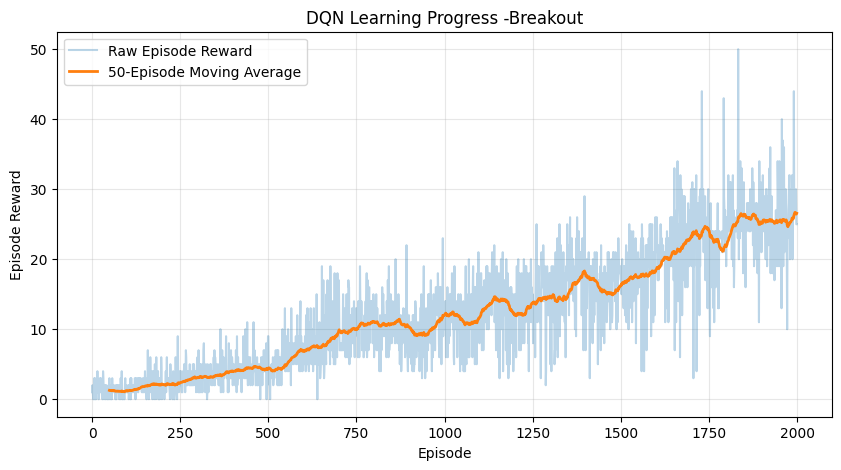

'\nQ-Value Behaviour \nAlthough average Q-values were not logged during training due to time constraints, \nwe expect Q-values to be highly unstable during early training and gradually stabilise\n as the value function converges. The use of experience replay and target networks mitigates\ndivergence and oscillations in value estimates.\n'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_episode_rewards(
    rewards,
    window_size=50,
    title="Episode Reward Over Time",
    ylabel="Episode Reward"
):
    """
    Plots raw episode rewards and a moving average.

    Parameters:
    rewards (list): episode-level rewards
    window_size (int): window for moving average
    """
    plt.figure(figsize=(10, 5))

    # Raw rewards
    plt.plot(rewards, alpha=0.3, label="Raw Episode Reward")

    # Moving average
    if len(rewards) >= window_size:
        moving_avg = np.convolve(
            rewards,
            np.ones(window_size) / window_size,
            mode="valid"
        )
        plt.plot(
            range(window_size - 1, len(rewards)),
            moving_avg,
            linewidth=2,
            label=f"{window_size}-Episode Moving Average"
        )

    plt.xlabel("Episode")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_episode_rewards(
    rewards_history,
    window_size=50,
    title="DQN Learning Progress -Breakout"
)
